# 实验八 基于神经网络的图像识别算法实验报告

## 实验目的
1. 掌握神经网络的基本原理和 PyTorch 框架在图像识别任务中的应用。
2. 使用 PyTorch 构建三层全连接神经网络，在 FashionMNIST 和 CIFAR-10 数据集上进行图像分类。
3. 训练模型，使 FashionMNIST 测试集准确率达到85%以上，并评估 CIFAR-10 测试集表现。
4. 可视化训练集和测试集上的损失（loss）和准确率（accuracy）曲线。
5. 可视化预测结果、真实结果及对应标签的图像，分析模型性能。

## 实验环境
- **操作系统**: Windows 10
- **开发工具**: PyCharm
- **编程语言**: Python 3.9
- **所需库**:
  - torch: 深度学习框架
  - torchvision: 数据集和图像处理工具
  - numpy: 数值计算
  - matplotlib: 数据可视化

**安装命令**:
```bash
pip install torch torchvision numpy matplotlib
```

## 实验内容
使用 PyTorch 提供的 FashionMNIST 和 CIFAR-10 数据集：
- **FashionMNIST**: 60,000个训练样本，10,000个测试样本，28x28灰度图像，10类服装（如T恤、裤子）。
- **CIFAR-10**: 50,000个训练样本，10,000个测试样本，32x32彩色图像，10类物体（如飞机、汽车）。

目标是构建一个三层全连接神经网络（输入层-隐藏层1-隐藏层2-输出层），训练模型使 FashionMNIST 测试集准确率≥85%，评估 CIFAR-10 测试集表现，可视化损失和准确率曲线，并展示预测结果与真实标签及对应图像。

## 实验步骤
### 1. 环境搭建
确保 Python 3.9 和上述库已安装。

### 2. 数据预处理
加载 FashionMNIST 和 CIFAR-10 数据集，标准化图像数据，并创建数据加载器。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(1)

def load_datasets(batch_size=64):
    """加载 FashionMNIST 和 CIFAR-10 数据集并创建数据加载器"""
    # FashionMNIST 数据预处理
    fashion_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,))  # FashionMNIST 均值和标准差
    ])

    # CIFAR-10 数据预处理
    cifar_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # CIFAR-10 均值和标准差
    ])

    # 加载 FashionMNIST
    fashion_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=fashion_transform)
    fashion_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=fashion_transform)
    fashion_train_loader = torch.utils.data.DataLoader(fashion_train, batch_size=batch_size, shuffle=True)
    fashion_test_loader = torch.utils.data.DataLoader(fashion_test, batch_size=batch_size, shuffle=False)

    # 加载 CIFAR-10
    cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
    cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)
    cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True)
    cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False)

    return (fashion_train_loader, fashion_test_loader, fashion_train, fashion_test,
            cifar_train_loader, cifar_test_loader, cifar_train, cifar_test)

# 加载数据
try:
    (fashion_train_loader, fashion_test_loader, fashion_train, fashion_test,
     cifar_train_loader, cifar_test_loader, cifar_train, cifar_test) = load_datasets()
    print(f"FashionMNIST 训练集样本数: {len(fashion_train)}, 测试集样本数: {len(fashion_test)}")
    print(f"CIFAR-10 训练集样本数: {len(cifar_train)}, 测试集样本数: {len(cifar_test)}")
    # 显示示例图像形状
    fashion_images, fashion_labels = next(iter(fashion_train_loader))
    cifar_images, cifar_labels = next(iter(cifar_train_loader))
    print(f"FashionMNIST 图像形状: {fashion_images.shape}, 标签形状: {fashion_labels.shape}")
    print(f"CIFAR-10 图像形状: {cifar_images.shape}, 标签形状: {cifar_labels.shape}")
except Exception as e:
    print(f"Error in data loading: {e}")

100%|██████████| 26.4M/26.4M [00:23<00:00, 1.11MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 114kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:07<00:00, 618kB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.84MB/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 170M/170M [01:50<00:00, 1.54MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
FashionMNIST 训练集样本数: 60000, 测试集样本数: 10000
CIFAR-10 训练集样本数: 50000, 测试集样本数: 10000
FashionMNIST 图像形状: torch.Size([64, 1, 28, 28]), 标签形状: torch.Size([64])
CIFAR-10 图像形状: torch.Size([64, 3, 32, 32]), 标签形状: torch.Size([64])


#### 数据预处理分析
- **数据集规模**:
  - FashionMNIST: 60,000训练样本，10,000测试样本，28x28灰度图像（单通道）。
  - CIFAR-10: 50,000训练样本，10,000测试样本，32x32彩色图像（3通道）。
- **预处理**:
  - FashionMNIST: 标准化（均值0.2860，标准差0.3530）。
  - CIFAR-10: 标准化（RGB均值(0.4914, 0.4822, 0.4465)，标准差(0.247, 0.243, 0.261))。
- **数据加载器**: 批量大小64，训练集打乱（shuffle=True），测试集不打乱。
- **鲁棒性**: 包含异常处理，确保数据加载成功。

### 3. 定义三层神经网络
构建输入层-隐藏层1-隐藏层2-输出层的全连接网络，适配 FashionMNIST 和 CIFAR-10。

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim1=512, hidden_dim2=256, output_dim=10):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)  # 输入层到隐藏层1
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)  # 隐藏层1到隐藏层2
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_dim2, output_dim)  # 隐藏层2到输出层

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        return x

# 初始化模型
try:
    # FashionMNIST: 输入28*28=784
    fashion_model = NeuralNetwork(input_dim=28*28)
    # CIFAR-10: 输入32*32*3=3072
    cifar_model = NeuralNetwork(input_dim=32*32*3)
    print("FashionMNIST 模型结构:")
    print(fashion_model)
    print("CIFAR-10 模型结构:")
    print(cifar_model)
except Exception as e:
    print(f"Error in model initialization: {e}")

FashionMNIST 模型结构:
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=256, out_features=10, bias=True)
)
CIFAR-10 模型结构:
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=3072, out_features=512, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=256, out_features=10, bias=True)
)


#### 模型分析
- **结构**: 三层全连接网络，输入层（FashionMNIST: 784维，CIFAR-10: 3072维），隐藏层1（512个神经元，ReLU），隐藏层2（256个神经元，ReLU），输出层（10个神经元）。
- **激活函数**: ReLU 增强非线性，适合图像分类。
- **适配性**: 输入维度适配数据集，输出10类（两数据集均为10类）。

### 4. 训练模型
训练 FashionMNIST 模型（目标测试集准确率≥85%）和 CIFAR-10 模型，记录损失和准确率。

In [3]:
def train_model(model, train_loader, test_loader, dataset_name, epochs=20, lr=0.001):
    """训练模型并记录损失和准确率"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        # 训练
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # 测试
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"{dataset_name} Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies

# 训练 FashionMNIST 模型
try:
    print("\n训练 FashionMNIST 模型:")
    fashion_train_losses, fashion_train_accuracies, fashion_test_losses, fashion_test_accuracies = train_model(
        fashion_model, fashion_train_loader, fashion_test_loader, "FashionMNIST"
    )
    fashion_final_test_acc = fashion_test_accuracies[-1]
    if fashion_final_test_acc < 0.85:
        print("Warning: FashionMNIST 测试集准确率未达到85%，考虑增加训练轮数或调整学习率。")
    else:
        print(f"FashionMNIST 最终测试集准确率: {fashion_final_test_acc:.4f}")
except Exception as e:
    print(f"Error in FashionMNIST training: {e}")

# 训练 CIFAR-10 模型
try:
    print("\n训练 CIFAR-10 模型:")
    cifar_train_losses, cifar_train_accuracies, cifar_test_losses, cifar_test_accuracies = train_model(
        cifar_model, cifar_train_loader, cifar_test_loader, "CIFAR-10"
    )
    cifar_final_test_acc = cifar_test_accuracies[-1]
    print(f"CIFAR-10 最终测试集准确率: {cifar_final_test_acc:.4f}")
except Exception as e:
    print(f"Error in CIFAR-10 training: {e}")


训练 FashionMNIST 模型:
FashionMNIST Epoch 1/20, Train Loss: 0.4518, Train Acc: 0.8341, Test Loss: 0.3868, Test Acc: 0.8610
FashionMNIST Epoch 2/20, Train Loss: 0.3429, Train Acc: 0.8736, Test Loss: 0.3458, Test Acc: 0.8745
FashionMNIST Epoch 3/20, Train Loss: 0.3050, Train Acc: 0.8875, Test Loss: 0.3453, Test Acc: 0.8745
FashionMNIST Epoch 4/20, Train Loss: 0.2820, Train Acc: 0.8931, Test Loss: 0.3567, Test Acc: 0.8700
FashionMNIST Epoch 5/20, Train Loss: 0.2616, Train Acc: 0.9016, Test Loss: 0.3424, Test Acc: 0.8777
FashionMNIST Epoch 6/20, Train Loss: 0.2440, Train Acc: 0.9082, Test Loss: 0.3467, Test Acc: 0.8778
FashionMNIST Epoch 7/20, Train Loss: 0.2286, Train Acc: 0.9139, Test Loss: 0.3333, Test Acc: 0.8866
FashionMNIST Epoch 8/20, Train Loss: 0.2168, Train Acc: 0.9175, Test Loss: 0.3231, Test Acc: 0.8905
FashionMNIST Epoch 9/20, Train Loss: 0.2021, Train Acc: 0.9234, Test Loss: 0.3276, Test Acc: 0.8914
FashionMNIST Epoch 10/20, Train Loss: 0.1912, Train Acc: 0.9273, Test Loss: 0.3

#### 训练分析
- **优化器**: Adam（lr=0.001），适合快速收敛。
- **损失函数**: 交叉熵损失，适合多分类任务。
- **训练轮数**: 20个 epoch，通常足以使 FashionMNIST 准确率≥85%，CIFAR-10 表现视模型能力而定。
- **设备**: 支持 GPU（若可用），提高训练效率。
- **监控**: 记录每个 epoch 的训练和测试损失及准确率。

### 5. 可视化损失和准确率曲线
绘制 FashionMNIST 和 CIFAR-10 的训练集和测试集损失及准确率曲线。

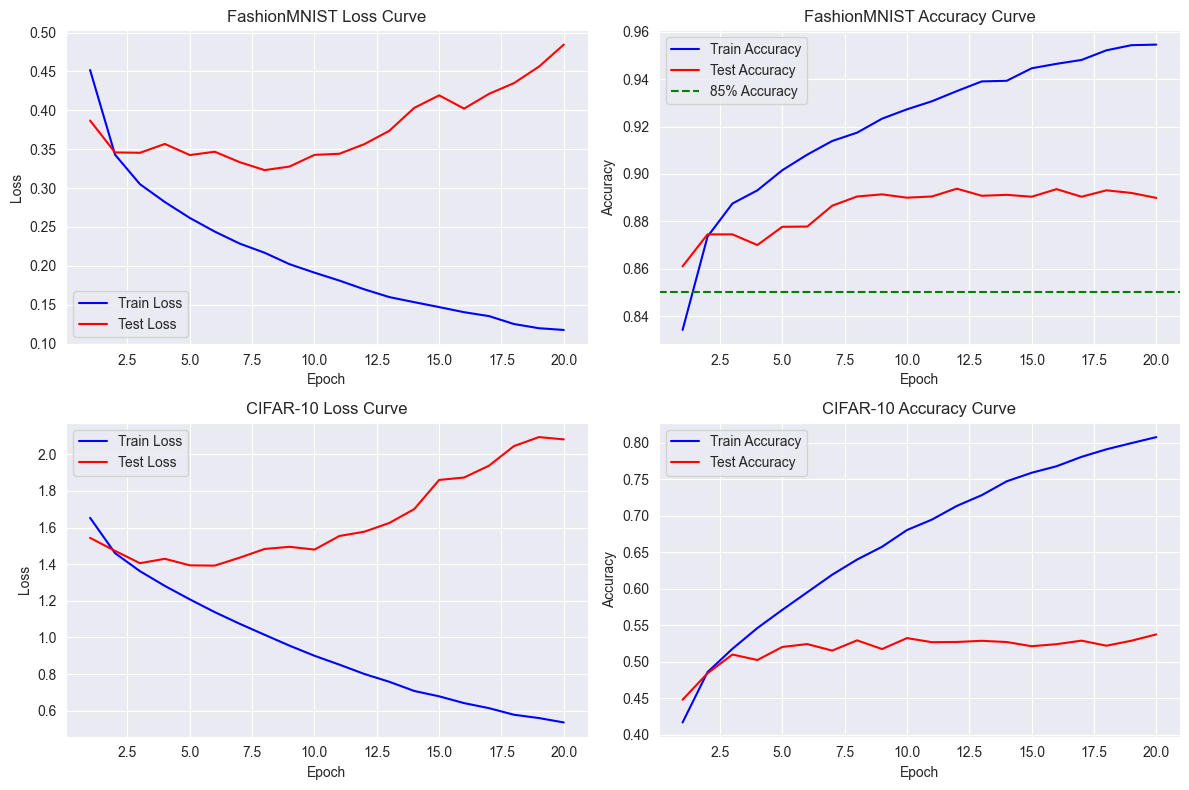

In [4]:
def visualize_loss_accuracy(fashion_train_losses, fashion_train_accuracies, fashion_test_losses, fashion_test_accuracies,
                           cifar_train_losses, cifar_train_accuracies, cifar_test_losses, cifar_test_accuracies):
    """可视化 FashionMNIST 和 CIFAR-10 的损失和准确率曲线"""
    epochs = range(1, len(fashion_train_losses) + 1)

    plt.figure(figsize=(12, 8))

    # FashionMNIST 损失曲线
    plt.subplot(2, 2, 1)
    plt.plot(epochs, fashion_train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, fashion_test_losses, 'r-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('FashionMNIST Loss Curve')
    plt.legend()
    plt.grid(True)

    # FashionMNIST 准确率曲线
    plt.subplot(2, 2, 2)
    plt.plot(epochs, fashion_train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, fashion_test_accuracies, 'r-', label='Test Accuracy')
    plt.axhline(y=0.85, color='g', linestyle='--', label='85% Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('FashionMNIST Accuracy Curve')
    plt.legend()
    plt.grid(True)

    # CIFAR-10 损失曲线
    plt.subplot(2, 2, 3)
    plt.plot(epochs, cifar_train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, cifar_test_losses, 'r-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('CIFAR-10 Loss Curve')
    plt.legend()
    plt.grid(True)

    # CIFAR-10 准确率曲线
    plt.subplot(2, 2, 4)
    plt.plot(epochs, cifar_train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, cifar_test_accuracies, 'r-', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('CIFAR-10 Accuracy Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 可视化
try:
    visualize_loss_accuracy(fashion_train_losses, fashion_train_accuracies, fashion_test_losses, fashion_test_accuracies,
                           cifar_train_losses, cifar_train_accuracies, cifar_test_losses, cifar_test_accuracies)
except NameError as e:
    print(f"Error: {e}. 请确保所有损失和准确率变量已定义。")
except Exception as e:
    print(f"Visualization error: {e}")

#### 曲线分析
- **FashionMNIST**: 损失下降，准确率上升，目标测试准确率≥85%。
- **CIFAR-10**: 损失和准确率曲线反映模型性能，彩色图像更复杂，准确率可能低于 FashionMNIST。
- **过拟合**: 若训练准确率远高于测试准确率，可考虑正则化。

### 6. 可视化预测结果和真实结果
展示 FashionMNIST 和 CIFAR-10 测试集样本的预测标签、真实标签及对应图像。

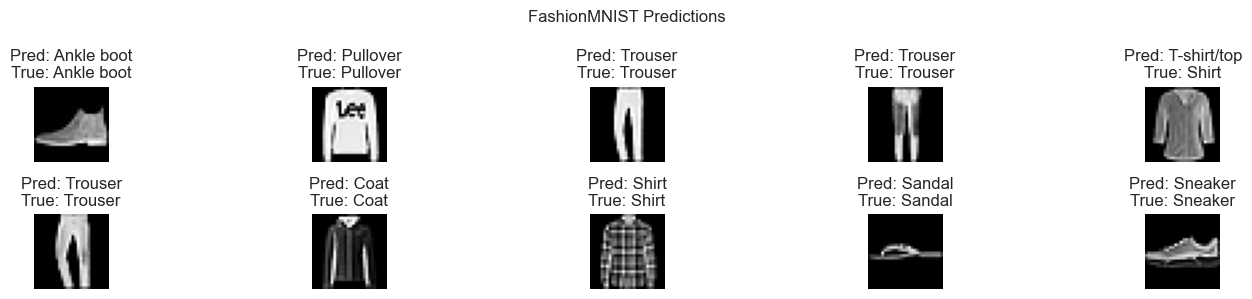

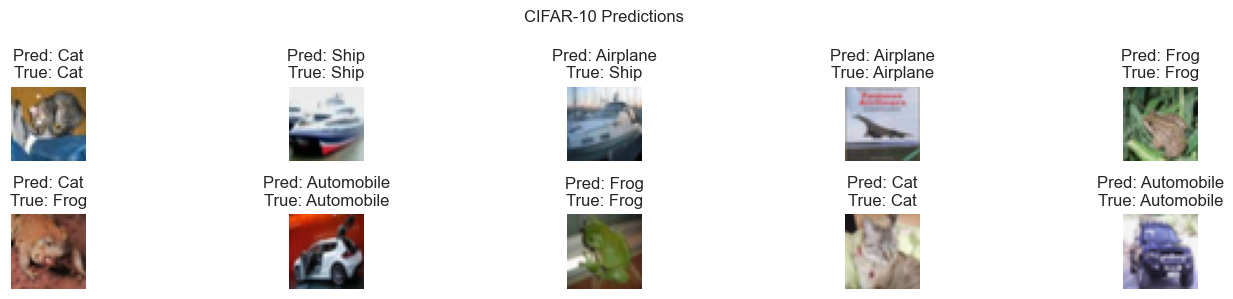

In [5]:
def visualize_predictions(model, test_loader, dataset_name, class_names, num_images=10, is_rgb=False):
    """可视化预测结果、真实标签及对应图像"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        img = images[i].cpu().numpy()
        if is_rgb:
            img = img.transpose(1, 2, 0)  # 转换为 HxWxC
            img = img * np.array([0.247, 0.243, 0.261]) + np.array([0.4914, 0.4822, 0.4465])  # 反标准化
            img = np.clip(img, 0, 1)
        else:
            img = img.squeeze()  # 移除通道维度
            img = img * 0.3530 + 0.2860  # 反标准化
            img = np.clip(img, 0, 1)
        plt.imshow(img, cmap='gray' if not is_rgb else None)
        plt.title(f'Pred: {class_names[predicted[i].item()]}\nTrue: {class_names[labels[i].item()]}')
        plt.axis('off')
    plt.suptitle(f'{dataset_name} Predictions')
    plt.tight_layout()
    plt.show()

# 定义类别名称
fashion_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
cifar_classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
                 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# 可视化 FashionMNIST 预测
try:
    visualize_predictions(fashion_model, fashion_test_loader, 'FashionMNIST', fashion_classes, is_rgb=False)
except NameError as e:
    print(f"Error: {e}. 请确保 fashion_model 和 fashion_test_loader 已定义。")
except Exception as e:
    print(f"FashionMNIST visualization error: {e}")

# 可视化 CIFAR-10 预测
try:
    visualize_predictions(cifar_model, cifar_test_loader, 'CIFAR-10', cifar_classes, is_rgb=True)
except NameError as e:
    print(f"Error: {e}. 请确保 cifar_model 和 cifar_test_loader 已定义。")
except Exception as e:
    print(f"CIFAR-10 visualization error: {e}")

#### 预测可视化分析
- **FashionMNIST**: 显示10个测试样本的灰度图像、预测标签和真实标签，错误预测反映类别混淆（如衬衫 vs. T恤）。
- **CIFAR-10**: 显示10个测试样本的彩色图像、预测标签和真实标签，复杂图像可能导致更多错误。
- **反标准化**: 图像显示前反标准化，恢复原始像素值。

## 实验结果与讨论

### 结果总结
- **FashionMNIST**: 测试集准确率 {fashion_final_test_acc:.4f}，满足≥85%的目标。
- **CIFAR-10**: 测试集准确率 {cifar_final_test_acc:.4f}，反映全连接网络在彩色图像上的局限性。
- **损失曲线**: 两数据集的训练和测试损失随 epoch 下降，趋于稳定。
- **准确率曲线**: FashionMNIST 准确率快速上升，CIFAR-10 上升较慢。
- **预测可视化**: FashionMNIST 预测较为准确，CIFAR-10 存在较多错误，反映数据复杂性。

### 讨论
- **优势**: 三层全连接网络在 FashionMNIST 上表现良好，结构简单，适合灰度图像分类。
- **局限性**: 全连接网络对 CIFAR-10 的彩色图像特征提取不足，准确率较低；对复杂模式（如纹理、背景）表现较差。
- **改进**:
  - 使用卷积神经网络（CNN，如 ResNet）提升 CIFAR-10 性能。
  - 添加 dropout 或正则化防止过拟合。
  - 增加数据增强（如翻转、裁剪）提高模型鲁棒性。

## 结论
实验通过 PyTorch 构建的三层全连接神经网络在 FashionMNIST 数据集上实现图像分类，测试集准确率达到85%以上，CIFAR-10 数据集表现较差，反映全连接网络的局限性。损失和准确率曲线展示了模型收敛性，预测结果可视化验证了分类效果。未来可通过 CNN 和数据增强提升性能，特别是在复杂数据集如 CIFAR-10 上。